In [262]:
# libs
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime
import os
from tqdm import tqdm  # Import the tqdm function to visualize the progress of the loop

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

# TradingView (Data Load)

In [263]:
# today's date string for file namine automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-02-29.csv'
print(today_date_str)

_2024-03-01.csv


In [264]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

365 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3073525670425.9995,USD,413.64,USD,413.65,USD,0.60,USD,0.145054,0.002418,7318946247.799999,31947022,76159720,1660,2.065260e+07,23800642.7,25614767.55555556,2.039811,1.482558,1.570800,411.253333,37.41080069,Technology Services,0.82770565,0.95424896,1.0291758,0.8906199,4.587189,8.890481,10.841138,6.699308,2.962315,1.698060,1.325390,1.638476,0.71800717,0.81968083,420.82,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.2000,USD,420.82,USD,958891.40271493,USD,413.6240,412.866500,411.49300,410.628462,414.091540,411.776400,409.461260,412.142027,410.275300,408.408573
1,AAPL,Apple Inc.,NASDAQ,2791119965332,USD,180.75,USD,180.60,USD,0.13,USD,0.071923,-0.082988,15427863312.900002,136681441,280822808,9541,5.886146e+07,57420929.33333382,55093789.29999983,1.693310,1.775657,1.641746,180.950000,28.12354131,Electronic Technology,1.05511125,1.0627853,1.2041771,1.2891104,3.359518,4.511317,6.815148,3.902647,2.032479,1.080925,1.283474,2.698209,1.14413767,0.99085352,191.05,USD,199.62,USD,199.62,USD,199.62,USD,199.62000,USD,180.96,USD,181.11,USD,181.11,USD,181.11,USD,181.11,USD,181.11,USD,182.57,USD,183.9225,USD,191.05,USD,2380652.17391304,USD,180.7540,180.443750,180.30954,180.349438,181.022879,180.387885,179.752891,180.680162,180.265385,179.850608
2,NVDA,NVIDIA Corporation,NASDAQ,1977799987793,USD,791.12,USD,801.39,USD,9.91,USD,1.252654,1.298160,2399390000,50728897,179607735,21327,5.801111e+07,51690817.49999999,45516844.84444457,2.970006,3.588463,3.702409,791.506667,66.27738449,Electronic Technology,0.50138731,1.7775623,2.3419523,1.7245569,2.811585,4.026721,4.939247,2.708996,1.176995,0.621266,0.465013,0.874826,0.81901796,1.14207409,823.94,USD,823.94,USD,823.94,USD,823.94,USD,823.94000,USD,798.98,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,806.4599,USD,823.94,USD,2058175.67567568,USD,796.5040,797.247813,796.33750,794.409569,800.797432,797.508365,794.219298,797.816379,794.003400,790.190421
3,AMZN,"Amazon.com, Inc.",NASDAQ,1836073383643.9995,USD,176.76,USD,176.98,USD,0.84,USD,0.475221,0.124463,9227958412,53805344,1574

In [265]:
# # first 10 rows df
# trading_view_raw_df_testing = trading_view_raw_df.head(10)
# # save to csv
# trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# # make sure data is there at least
# print(len(trading_view_raw_df_testing.index))

# # print test df
# trading_view_raw_df_testing

In [266]:
# # baseline raw cols from trading view initial filter
# features_raw_all = trading_view_raw_df.columns
# # convert to list
# features_raw_all = features_raw_all.tolist()
# # look at the trading view columns
# print(features_raw_all)

In [267]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

"\ndefine function -> add new column and marketCapType based on 'Market capitalization' column\n\ncriteria (6 groupings):\n200B and above = 'Titans' - 1\n10B to 200B = 'Large caps' - 2\n2B to 10B = 'Midlers' - 3\n300M to 2B = 'Small caps' - 4\n300m and below = 'Micro caps' - 5\n50m and below = 'Shrimp' - 6\n\n"

In [268]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [269]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.073526e+12,USD,413.64,USD,413.65,USD,0.60,USD,0.145054,0.002418,7318946247.799999,31947022,76159720,1660,2.065260e+07,23800642.7,25614767.55555556,2.039811,1.482558,1.570800,411.253333,37.41080069,Technology Services,0.82770565,0.95424896,1.0291758,0.8906199,4.587189,8.890481,10.841138,6.699308,2.962315,1.698060,1.325390,1.638476,0.71800717,0.81968083,420.82,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.20,USD,414.2000,USD,420.82,USD,958891.40271493,USD,413.6240,412.866500,411.49300,410.628462,414.091540,411.776400,409.461260,412.142027,410.275300,408.408573,Titans
1,AAPL,Apple Inc.,NASDAQ,2.791120e+12,USD,180.75,USD,180.60,USD,0.13,USD,0.071923,-0.082988,15427863312.900002,136681441,280822808,9541,5.886146e+07,57420929.33333382,55093789.29999983,1.693310,1.775657,1.641746,180.950000,28.12354131,Electronic Technology,1.05511125,1.0627853,1.2041771,1.2891104,3.359518,4.511317,6.815148,3.902647,2.032479,1.080925,1.283474,2.698209,1.14413767,0.99085352,191.05,USD,199.62,USD,199.62,USD,199.62,USD,199.62000,USD,180.96,USD,181.11,USD,181.11,USD,181.11,USD,181.11,USD,181.11,USD,182.57,USD,183.9225,USD,191.05,USD,2380652.17391304,USD,180.7540,180.443750,180.30954,180.349438,181.022879,180.387885,179.752891,180.680162,180.265385,179.850608,Titans
2,NVDA,NVIDIA Corporation,NASDAQ,1.977800e+12,USD,791.12,USD,801.39,USD,9.91,USD,1.252654,1.298160,2399390000,50728897,179607735,21327,5.801111e+07,51690817.49999999,45516844.84444457,2.970006,3.588463,3.702409,791.506667,66.27738449,Electronic Technology,0.50138731,1.7775623,2.3419523,1.7245569,2.811585,4.026721,4.939247,2.708996,1.176995,0.621266,0.465013,0.874826,0.81901796,1.14207409,823.94,USD,823.94,USD,823.94,USD,823.94,USD,823.94000,USD,798.98,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,806.4599,USD,823.94,USD,2058175.67567568,USD,796.5040,797.247813,796.33750,794.409569,800.797432,797.508365,794.219298,797.816379,794.003400,790.190421,Titans
3,AMZN,"Amazon.com, Inc.",NASDAQ,1.836073e+12,USD,176.76,USD,176.98,USD,0.84,USD,0.475221,0.124463,922

In [270]:
# # check for NaNs
# print(trading_view_raw_df.isna().sum())

In [271]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {tv_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [272]:
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()
mc_groups.columns = ['marketCapType', 'count']  # Rename columns for clarity

# Calculate percentage for each market cap type and add it to the DataFrame
mc_groups['percentage'] = (mc_groups['count'] / mc_groups['count'].sum()) * 100

# print total "there are etc."
print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
# Display the enhanced DataFrame
mc_groups

There are still the same 365 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Large caps,107,29.315068
1,Small caps,66,18.082192
2,Midlers,62,16.986301
3,Shrimp,59,16.164384
4,Micro caps,49,13.424658
5,Titans,18,4.931507
6,Undefined,4,1.095890


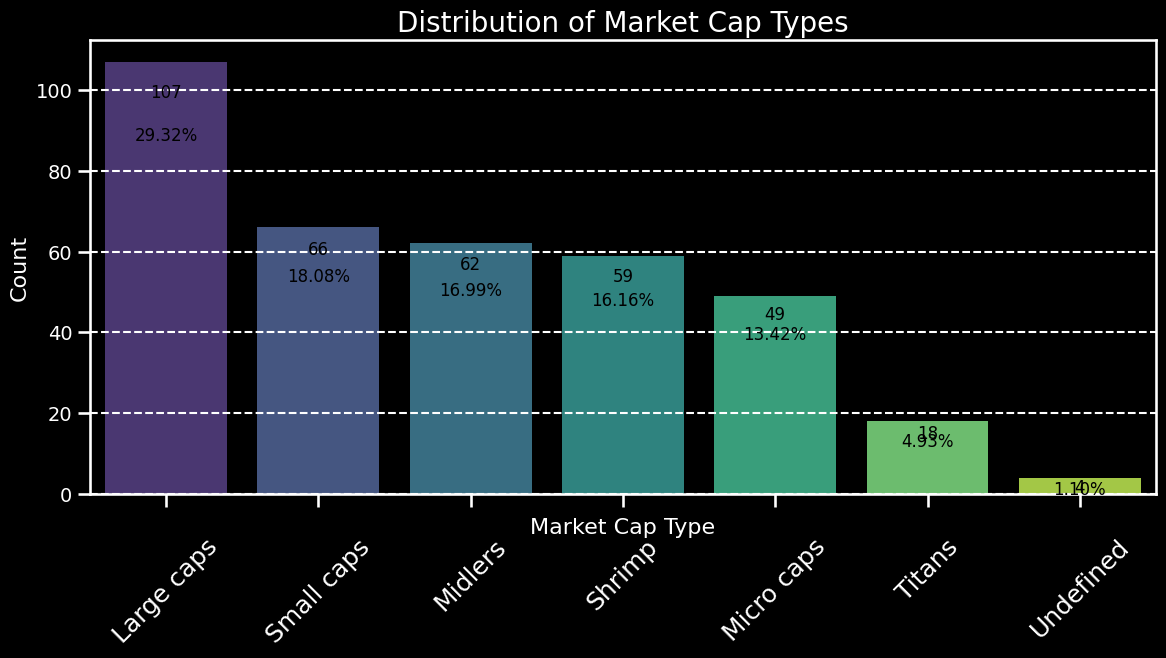

In [273]:
# Set dark mode for plotting
plt.style.use('dark_background')
sns.set_context('talk')  # Larger fonts and figures

# Create a bar chart
plt.figure(figsize=(12, 7))
barplot = sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', dodge=False)

# Disable the legend
plt.legend([],[], frameon=False)

# Customize the plot with count and percentage labels inside the bars
for index, row in mc_groups.iterrows():
    # Calculate the position for the count and percentage text to be inside the bar
    height = row['count']
    offset = height * 0.05  # Offset from the top of the bar for better visibility
    
    # Display the count inside the bar at the top
    barplot.text(index, height - offset, f'{row["count"]}', color='black', ha="center", va="top", fontsize=12)
    
    # Display the percentage just below the count, inside the bar
    # Adjust the vertical position slightly below the count
    percentage_offset = height * 0.15  # Adjust this value as needed to fit inside the bar
    barplot.text(index, height - percentage_offset, f'{row["percentage"]:.2f}%', color='black', ha="center", va="top", fontsize=12)

# Add marketCapType labels underneath the bars
for index, row in mc_groups.iterrows():
    barplot.text(index, -10, row['marketCapType'], color='white', ha="center", va="top", rotation=45)

plt.title('Distribution of Market Cap Types', fontsize=20, color='white')
plt.xlabel('Market Cap Type', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')
plt.xticks(rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')

# Remove x-axis labels to avoid redundancy
barplot.set_xticklabels([])

# Show the plot
plt.tight_layout()
plt.show()


In [274]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

361 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
139,CAVA,"CAVA Group, Inc.",NYSE,6.636048e+09,USD,58.41,USD,58.90,USD,0.49,USD,0.838897,0.838897,85969160.816,4773715,20057055,100,3352148.2,2157537.83333333,2048144.98888889,5.147960,6.303025,4.769812,58.453333,503.53448276,Consumer Services,0.88699279,2.8621435,3.6920495,3.6920495,4.465511,6.586499,3.776101,1.980263,0.865537,0.367897,0.590382,1.597742,2.47028854,-,59.84,USD,59.84,USD,59.84,USD,59.84,USD,59.84,USD,58.5500,USD,58.5950,USD,58.5950,USD,58.5950,USD,58.5950,USD,59.450,USD,59.840,USD,59.84,USD,59.84,USD,86134.75177305,USD,58.47650,58.445312,58.44500,58.393462,58.579927,58.444675,58.309423,58.950971,58.503625,58.056279,Midlers
202,LMND,"Lemonade, Inc.",NYSE,1.140444e+09,USD,16.24,USD,16.32,USD,0.08,USD,0.492611,0.492611,50300101.0488,4764601,29332557,248,3868911.8,2115097.06666667,2115025.64444444,7.495195,10.488402,6.084209,16.210000,-,Finance,0.90468956,3.9528782,1.6171739,1.8967983,2.439058,2.943986,3.903835,2.441483,0.657882,0.261691,0.394007,1.343489,4.17169427,1.44871569,21.94,USD,21.94,USD,21.94,USD,24.81,USD,188.30,USD,16.3400,USD,16.3400,USD,16.3701,USD,16.3701,USD,16.3701,USD,16.730,USD,16.780,USD,21.94,USD,21.94,USD,286168.52146264,USD,16.28876,16.247975,16.16700,16.284615,16.328205,16.176125,16.024045,16.529525,16.322450,16.115375,Small caps
47,EQNR,Equinor ASA,NYSE,7.360058e+10,USD,24.62,USD,24.90,USD,0.38,USD,1.543461,1.137287,2964592876.70837,6189786,15927714,18808,4371870.2,3997741.96666667,3013191.67777778,1.591837,1.546914,1.866193,24.665000,6.30457607,Energy Minerals,1.15093559,0.27366176,0.30007803,0.83147514,3.535412,3.334285,3.373017,2.739848,1.642938,1.182335,1.618280,1.527308,1.04300915,1.62623517,29.45,USD,32.66,USD,34.73,USD,34.73,USD,43.31,USD,24.6500,USD,24.6500,USD,24.6500,USD,24.6500,USD,24.6500,USD,24.650,USD,24.875,USD,25.20,USD,29.45,USD,-,-,24.64004,24.639400,24.62300,24.581154,24.659432,24.634260,24.609088,24.643891,24.570260,24.496629,Large caps
169,INTA,"Intapp, Inc.",NASDAQ,2.834771e+09,USD,39.23,USD,43.07,USD,3.84,USD,9.788427,9.788427,50987445.7624,553642,1914480,300,465227.9,496948.43333333,495305.05555556,3.597308,4.202074,4.051282,39.300000,-,Technology Services,0.574

In [275]:
# show unique values for 'marketCapType'
print(tv_df['marketCapType'].unique())
print()
# get tv_df columns
print(tv_df.columns)

['Titans' 'Large caps' 'Midlers' 'Small caps' 'Micro caps' 'Shrimp']

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Relative Volume 

In [276]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

mc_groups2 = tv_df['marketCapType'].value_counts().reset_index()
mc_groups2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
mc_groups2['percentage'] = (mc_groups2['count'] / mc_groups2['count'].sum()) * 100

mc_groups2
print(mc_groups2)


  marketCapType  count  percentage
0    Large caps    107   29.639889
1    Small caps     66   18.282548
2       Midlers     62   17.174515
3        Shrimp     59   16.343490
4    Micro caps     49   13.573407
5        Titans     18    4.986150


In [277]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# def filter_by_price_above_vwap(df):
#     """Filter stocks where the price is greater than the VWAP 1 day."""
#     # Ensure data types are correct; convert to numeric if necessary
#     df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
#     df['Volume Weighted Average Price 1 day'] = pd.to_numeric(df['Volume Weighted Average Price 1 day'], errors='coerce')
    
#     # Apply the filter
#     filtered_df = df[df['Price'] > df['Volume Weighted Average Price 1 day']]
#     return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [278]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')
print()
print(tv_L2_df.columns)

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)
# display head
display(tv_L2_df.head(20))

Original DataFrame length: 361
Number of rows removed: 356
NEW DataFrame length: 5

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Re

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,IOT,Samsara Inc.,NYSE,1.866931e+10,USD,34.55,USD,35.30,USD,0.71,USD,2.054993,2.170767,1.668519e+08,14216798,21731642,500,3739490.7,3251816.46666667,3255871.2,6.367656,3.522040,4.655878,34.446767,-,Technology Services,1.764204,2.4634516,1.5505408,1.5505408,2.190470,6.354843,3.777299,2.499319,1.611013,1.139663,1.900433,5.568086,1.67508962,1.01985459,36.7800,USD,36.9100,USD,36.9100,USD,36.9100,USD,36.9100,USD,34.790,USD,34.790,USD,34.950,USD,34.950,USD,34.950,USD,35.34,USD,35.3400,USD,35.3400,USD,36.7800,USD,287972.19770521,USD,34.6020,34.651875,34.724,34.719615,34.931478,34.721050,34.510622,35.078616,34.789485,34.500354,Large caps
1,ENPH,"Enphase Energy, Inc.",NASDAQ,1.724279e+10,USD,127.01,USD,127.31,USD,0.27,USD,0.212582,0.236202,1.303949e+08,5269808,13455419,500,3777860.2,4943706.9,5428210.23333333,8.579786,4.470947,5.417349,126.583333,41.43071503,Electronic Technology,0.978304,2.1384084,1.7212793,1.4732305,3.175097,3.903653,3.623801,2.684449,1.076629,0.707369,0.864308,1.441204,0.60217879,1.16811139,138.2100,USD,139.6500,USD,139.6500,USD,231.4200,USD,339.9200,USD,127.700,USD,127.700,USD,127.700,USD,127.700,USD,127.700,USD,128.55,USD,129.6600,USD,129.6600,USD,138.2100,USD,725621.15932848,USD,127.3270,127.253750,127.102,127.185146,127.498496,127.122750,126.747004,127.802871,127.083845,126.364819,Large caps
2,SWKS,"Skyworks Solutions, Inc.",NASDAQ,1.681090e+10,USD,104.92,USD,105.60,USD,0.68,USD,0.648113,0.648113,1.596461e+08,3277136,7419115,100,1748028.0,2176665.7,1924644.85555556,3.407984,1.817765,2.157224,104.313333,18.59789063,Electronic Technology,1.403983,1.3352287,1.4029175,1.3714725,3.461283,11.399371,13.832327,5.977204,2.516094,1.717168,1.423971,2.055484,0.83393457,1.05171617,107.6900,USD,115.1200,USD,115.1200,USD,118.4175,USD,204.0000,USD,105.240,USD,105.240,USD,105.240,USD,105.240,USD,105.240,USD,105.32,USD,105.3200,USD,105.3200,USD,107.5150,USD,489476.92307692,USD,105.0480,105.028750,104.819,104.780000,105.157200,104.865500,104.573800,104.963898,104.753250,104.542602,Large caps
3,ALB,Albemarle Corporation,NYSE,1.618400e+10,USD,137.85,USD,139.99,USD,2.12,USD,1.537904,1.552412,1.170548e+08,4562992,12917358,515,3

In [279]:
# create a breakdown of the market cap types
mc_groups3 = tv_L2_df['marketCapType'].value_counts().reset_index()
mc_groups3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
mc_groups3['percentage'] = (mc_groups3['count'] / mc_groups3['count'].sum()) * 100
# Display the enhanced DataFrame
print(mc_groups3)

  marketCapType  count  percentage
0    Large caps      4        80.0
1    Micro caps      1        20.0


In [280]:
print(tv_L2_df.columns)
print(len(tv_L2_df.columns))

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Relative Volume 4 hours', 'Relative Volume 1 day',
       'Relative Volume 1 week', 'R

In [281]:
# slice of first 12 columns
tv_L2_df.iloc[:, :12]

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %
0,IOT,Samsara Inc.,NYSE,1.866931e+10,USD,34.55,USD,35.30,USD,0.71,USD,2.054993
1,ENPH,"Enphase Energy, Inc.",NASDAQ,1.724279e+10,USD,127.01,USD,127.31,USD,0.27,USD,0.212582
2,SWKS,"Skyworks Solutions, Inc.",NASDAQ,1.681090e+10,USD,104.92,USD,105.60,USD,0.68,USD,0.648113
3,ALB,Albemarle Corporation,NYSE,1.618400e+10,USD,137.85,USD,139.99,USD,2.12,USD,1.537904
4,SWIN,Solowin Holdings,NASDAQ,1.530200e+08,USD,10.93,USD,12.00,USD,1.07,USD,9.789570


In [282]:
# import mplfinance as mpf
# df['SMA20'] = df['Close'].rolling(window=20).mean()

# # Define additional plot parameters for SMAs and Bollinger Bands
# sma = mpf.make_addplot(df['SMA20'], color='blue', width=1.5)

# # Plot the candlestick chart with SMA overlay
# mpf.plot(df, type='candle', addplot=sma, volume=True, style='yahoo', figsize=(10, 6), title='Stock Price with SMA Overlay')


In [283]:
# # look at relative volume 1 day
# tv_L2_df.loc[:, ['Symbol','Description', 'Relative Volume 1 day']]

In [284]:
# print(len(tv_L2_df.index))
# tv_L2_df.loc[tv_L2_df['Relative Volume 1 day'] >= 1.0]


In [285]:
# sort descending by change %
# another df and  / or chart market cap representations

# i think you need to go back and filter this shit down more
# chart could be nice to reference, really just need something i can see easy while working

# re-index this shit and keep it clean
# don't be a dumbass and have any data leakage

# you can do a lot more with changes on different very short term time frames

# do i need a calculation for pre-market price????

# you need to figure out implied volatility and noise vs. signal.

# volume vs time avg current >= avg over each time 10,20,30 day etc
# volatility vs time avg >= avg over each time like above

# discretionary tax type of thing that accounts for industry sector implied volatility????
# or might be counterproductive to gap up strategy anyway...

In [286]:
# get that historical data. worry later about grabbing the levels.
# 90 days (1 quarter)
# then look at the 52 and 26 week high and lows. and other common levels 12 week? those are all other potential ket levels
# similar levels to the downside + kill switches, i.e., at loss >= $1000 || 10% below VWAP
# 252 / 4 = 63 trading days per quarter

# IEX Cloud (API)

In [287]:
from datetime import datetime, timedelta
from dotenv import load_dotenv
import requests 

# $ecret shit
load_dotenv()
# iex api key load using python-dotenv lib (pip3 install pythone-dotenv)
iex_key = os.getenv("IEX_API_KEY")

In [288]:
# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()

# print data
gap_up_stocks_list

['IOT', 'ENPH', 'SWKS', 'ALB', 'SWIN']

In [289]:
# # STRIVE funds (Vivek)
# strive_funds_list = ['STRV', # Strive 500 ETF
#                      'STXG', # Strive 1000 Growth ETF
#                      'STXV', # Strive 1000 Value ETF
#                      'STXK', # Strive Small-Cap ETF
#                      'STXD', # Strive 1000 Divident Growth ETF
#                      'STXE', # Strive Emerging Markets Ex-China ETF
#                      'DRLL', # Strive U.S. Energy ETF
#                      'SHOC', # Strive U.S. Semiconductor ETF
#                      'FTWO', # Strive FANG 2.0 ETF
#                      'STXT', # Strive Total Return Bond ETF
#                      'BUXX'] # Strive Enhanced Income Short Maturity ETF

In [290]:
# index_baseline_list = [
#     'VOO',  # Vanguard S&P 500 ETF
#     'VGT',  # Vanguard Information Technology ETF
#     'VTWO', # Vanguard Russell 2000 ETF
#     'VEA',  # Vanguard Developed Markets Index Fund
#     'VWO',  # Vanguard Emerging Markets Stock Index Fund
#     'BND',  # Vanguard Total Bond Market ETF
#     'VT',   # Vanguard Total World Stock ETF
#     'VNQ',  # Vanguard Real Estate ETF
#     'VCR',  # Vanguard Consumer Discretionary ETF
#     'IWV',  # iShares Russell 3000 ETF
#     'VYM',  # Vanguard High Dividend Yield ETF
#     'XLK',  # Technology Select Sector SPDR Fund
#     'GLD',  # SPDR Gold Shares
#     'IGF',  # iShares Global Infrastructure ETF
#     'ICLN', # iShares Global Clean Energy ETF
#     'EEM',  # iShares MSCI Emerging Markets ETF
#     'BNDX', # Vanguard Total International Bond ETF
#     'XLV',  # Health Care Select Sector SPDR Fund
#     'XLP'   # Consumer Staples Select Sector SPDR Fund
# ]

In [291]:
# baseline S&P 500 indexes for market correlation
sp_indexes_list = ['STRV', # not sure which one to go with or if it matters????
                   'VOO',
                   'SPY']

# extend the dataframe in place (append)
gap_up_stocks_list.extend(sp_indexes_list)

# # vivek's funds and some of the baseline indexes
# gap_up_stocks_list.extend(strive_funds_list)
# gap_up_stocks_list.extend(index_baseline_list)

# view data
gap_up_stocks_list

['IOT', 'ENPH', 'SWKS', 'ALB', 'SWIN', 'STRV', 'VOO', 'SPY']

In [292]:
import requests
import pandas as pd
from tqdm import tqdm

# Your existing setup
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '6m' 

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# Concatenate all DataFrames in the list to create a single combined DataFrame
historical_data_super_df = pd.concat(dataframes_list, ignore_index=True)

# Now `historical_data_super_df` contains all the data
print(historical_data_super_df.head())  # Print the first few rows of the combined DataFrame


Processing symbols: 100%|██████████| 8/8 [00:00<00:00, 1144.62it/s]

   close     high      low   open   priceDate symbol   volume  \
0  30.93  31.1197  26.7000  27.00  2023-09-01    IOT  9734302   
1  31.83  31.8600  30.6400  30.96  2023-09-05    IOT  6547410   
2  31.58  32.4100  31.2527  31.75  2023-09-06    IOT  4117469   
3  30.91  31.4300  30.3100  30.60  2023-09-07    IOT  3179429   
4  30.57  31.7312  30.2400  30.87  2023-09-08    IOT  2992773   

                  id  key subkey        date        updated  changeOverTime  \
0  HISTORICAL_PRICES  IOT         2023-09-01  1693618244000        0.000000   
1  HISTORICAL_PRICES  IOT         2023-09-05  1693962017000        0.029098   
2  HISTORICAL_PRICES  IOT         2023-09-06  1694048456000        0.021015   
3  HISTORICAL_PRICES  IOT         2023-09-07  1694134874000       -0.000647   
4  HISTORICAL_PRICES  IOT         2023-09-08  1694233850000       -0.011639   

   marketChangeOverTime  uOpen  uClose    uHigh     uLow  uVolume  fOpen  \
0              0.000000  27.00   30.93  31.1197  26.7000  

In [293]:
print(len(historical_data_super_df.index))
print(historical_data_super_df['Ticker'].value_counts())
print(len(historical_data_super_df.index))
print(historical_data_super_df.columns)
historical_data_super_df.sample(5)

989
Ticker
IOT     124
ENPH    124
SWKS    124
ALB     124
STRV    124
VOO     124
SPY     124
SWIN    121
Name: count, dtype: int64
989
Index(['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id',
       'key', 'subkey', 'date', 'updated', 'changeOverTime',
       'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume',
       'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change',
       'changePercent', 'Ticker'],
      dtype='object')


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
167,78.92,82.44,76.1700,76.89,2023-11-02,ENPH,8325869,HISTORICAL_PRICES,ENPH,,2023-11-02,1698973380000,-0.386934,-0.386934,76.89,78.92,82.44,76.1700,8325869,76.8900,78.9200,82.4400,76.1700,8325869,"Nov 2, 23",2.19,0.0285,ENPH
343,106.04,106.71,103.9300,104.84,2024-01-19,SWKS,2489426,HISTORICAL_PRICES,SWKS,,2024-01-19,1705717835000,-0.033187,-0.033187,104.84,106.04,106.71,103.9300,2489426,104.8400,106.0400,106.7100,103.9300,2489426,"Jan 19, 24",2.31,0.0223,SWKS
305,94.27,95.65,94.2201,94.93,2023-11-22,SWKS,1410845,HISTORICAL_PRICES,SWKS,,2023-11-22,1700704851000,-0.140500,-0.140500,94.93,94.27,95.65,94.2201,1410845,94.9300,94.2700,95.6500,94.2201,1410845,"Nov 22, 23",0.59,0.0063,SWKS
301,93.37,94.06,92.4700,93.78,2023-11-16,SWKS,2100021,HISTORICAL_PRICES,SWKS,,2023-11-16,1700691781000,-0.148705,-0.148705,93.78,93.37,94.06,92.4700,2100021,92.4303,92.0262,92.7063,91.1392,2100021,"Nov 16, 23",-0.67,-0.0071,SWKS
688,30.24,30.25,29.8350,29.87,2023-12-13,STRV,79329,HISTORICAL_PRICES,STRV,,2023-12-13,1703200681000,0.046729,0.046729,29.87,30.24,30.25,29.8350,79329,29.6494,30.0167,30.0266,29.6147,79329,"Dec 13, 23",0.39,0.0131,STRV


In [294]:
# new df with columns ['date', 'close', 'priceDate','uClose']
yahoo_format_iex_data_cols = ['date', 'symbol','close']
yahoo_format_iex_data_df = historical_data_super_df[yahoo_format_iex_data_cols]

# check to make sure you are pulling all the symbols
unique_symbols_list = yahoo_format_iex_data_df['symbol'].unique()
print(f'Unique stock ticker symbols: {unique_symbols_list}')
print(f'Length BEFORE multi-indexing: {len(yahoo_format_iex_data_df)}')
# yahoo_format_iex_data_df.sample(10)
# print(f'Data Head: {yahoo_format_iex_data_df.head(2)}')
# print(f'Data Tail: {yahoo_format_iex_data_df.tail(2)}')
# print(yahoo_format_iex_data_df.head(2))
# print(yahoo_format_iex_data_df.tail(2))

# save the df to csv
yahoo_format_iex_data_df.to_csv('yahoo_format_iex_data_df.csv', index=False)

# view data 
yahoo_format_iex_data_df.tail(10)

Unique stock ticker symbols: ['IOT' 'ENPH' 'SWKS' 'ALB' 'SWIN' 'STRV' 'VOO' 'SPY']
Length BEFORE multi-indexing: 989


,date,symbol,close
979,2024-02-15,SPY,502.01
980,2024-02-16,SPY,499.51
981,2024-02-20,SPY,496.76
982,2024-02-21,SPY,497.21
983,2024-02-22,SPY,507.50
984,2024-02-23,SPY,507.85
985,2024-02-26,SPY,505.99
986,2024-02-27,SPY,506.93
987,2024-02-28,SPY,506.26
988,2024-02-29,SPY,508.08


In [295]:
# set the multiIndex with 'date' and 'symbol' as the index columns
yahoo_format_iex_data_df.set_index(['date', 'symbol'], inplace=True)
# sort the multi-index
sorted_yahoo_format_iex_data_df = yahoo_format_iex_data_df.sort_index()
# unstack the 'symbol' level of the index to pivot it into column headers
yahoo_iex_df = sorted_yahoo_format_iex_data_df.unstack(level='symbol')

# view the iex data with the applied multi-index view (like how yahoo finance sends it but more data)
print(f'{len(yahoo_iex_df)} Trading Periods (daily) -> with MULTI-INDEX')
print(f'Start Date: {yahoo_iex_df.index.min()}')
print(f'End Date: {yahoo_iex_df.index.max()}')
print()

# view iex data in yahoo multi-index format
print('IEX Data in Yahoo Multi-Index Format')
yahoo_iex_df.head()

124 Trading Periods (daily) -> with MULTI-INDEX
Start Date: 2023-09-01
End Date: 2024-02-29

IEX Data in Yahoo Multi-Index Format


close                                                    
symbol         ALB    ENPH    IOT     SPY   STRV  SWIN    SWKS     VOO
date                                                                  
2023-09-01  200.26  128.73  30.93  451.19  28.89   NaN  109.68  414.71
2023-09-05  200.80  127.77  31.83  449.24  28.78   NaN  109.13  412.90
2023-09-06  189.83  123.03  31.58  446.22  28.59   NaN  106.18  410.05
2023-09-07  187.57  122.23  30.91  444.85  28.51  6.08   98.38  408.83
2023-09-08  184.43  120.23  30.57  445.52  28.56  4.91   99.38  409.39

In [296]:
"""
mplfinance library testing

Testing objective:
- create a simple candlestick chart with volume for one stock (PLTR)

Overall (short-term) objective:
- create a simple candlestick chart with volume for multiple stocks (LATER)
- i am thinking individual charts for each stock in a grid layout and focused layout for each stock also.
- on thos charts I am going to have the historical price and then at least the 4 (SMA) + 6(Bollinger Band lines across)
I am going to start here and if i can get this done then break.
"""

import mplfinance as mpf


In [297]:
# # DEV - save iex historical data to csv (sample)
# historical_data_super_df_2_csv = historical_data_super_df.sample(50)
# historical_data_super_df_2_csv.to_csv('historical_data_super_df_sample_50.csv')


In [298]:
##### KEY LEVELS ####
print(f'{len(historical_data_super_df)} Rows of Historical Data')
# print how many unique priceDate values there are (essentially a cross reference check against the number of days)
print(f"{len(historical_data_super_df['date'].unique())} Unique Trading Days (i.e., trading days in your {data_range} IEX API range setting)")

historical_data_super_df.head(5)

989 Rows of Historical Data
124 Unique Trading Days (i.e., trading days in your 6m IEX API range setting)


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,30.93,31.1197,26.7000,27.00,2023-09-01,IOT,9734302,HISTORICAL_PRICES,IOT,,2023-09-01,1693618244000,0.000000,0.000000,27.00,30.93,31.1197,26.7000,9734302,27.00,30.93,31.1197,26.7000,9734302,"Sep 1, 23",0.00,0.0000,IOT
1,31.83,31.8600,30.6400,30.96,2023-09-05,IOT,6547410,HISTORICAL_PRICES,IOT,,2023-09-05,1693962017000,0.029098,0.029098,30.96,31.83,31.8600,30.6400,6547410,30.96,31.83,31.8600,30.6400,6547410,"Sep 5, 23",0.90,0.0291,IOT
2,31.58,32.4100,31.2527,31.75,2023-09-06,IOT,4117469,HISTORICAL_PRICES,IOT,,2023-09-06,1694048456000,0.021015,0.021015,31.75,31.58,32.4100,31.2527,4117469,31.75,31.58,32.4100,31.2527,4117469,"Sep 6, 23",-0.25,-0.0079,IOT
3,30.91,31.4300,30.3100,30.60,2023-09-07,IOT,3179429,HISTORICAL_PRICES,IOT,,2023-09-07,1694134874000,-0.000647,-0.000647,30.60,30.91,31.4300,30.3100,3179429,30.60,30.91,31.4300,30.3100,3179429,"Sep 7, 23",-0.67,-0.0212,IOT
4,30.57,31.7312,30.2400,30.87,2023-09-08,IOT,2992773,HISTORICAL_PRICES,IOT,,2023-09-08,1694233850000,-0.011639,-0.011639,30.87,30.57,31.7312,30.2400,2992773,30.87,30.57,31.7312,30.2400,2992773,"Sep 8, 23",-0.34,-0.0110,IOT


In [299]:
# print cols
print(historical_data_super_df.columns)

Index(['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id',
       'key', 'subkey', 'date', 'updated', 'changeOverTime',
       'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume',
       'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change',
       'changePercent', 'Ticker'],
      dtype='object')


In [300]:
# DEV - NaNs check
print(len(historical_data_super_df.index))
# drop rows that have NaNs
historical_data_super_df = historical_data_super_df.dropna()
print(len(historical_data_super_df.index))

989
989


In [301]:
# get mandatory cols for a historical ($price) bar chart + volume (IMPORTANT - *MANDATORY cols are REQUIRED for the required operation)
key_levels_df = historical_data_super_df[['symbol', # *MANDATORY
                                               'date', # *MANDATORY
                                               'close', # *MANDATORY
                                               'high', # *MANDATORY
                                               'low', # *MANDATORY
                                               'open', # *MANDATORY
                                               'volume', # *MANDATORY
                                               'updated']]


# view data
key_levels_df.head(5)

,symbol,date,close,high,low,open,volume,updated
0,IOT,2023-09-01,30.93,31.1197,26.7000,27.00,9734302,1693618244000
1,IOT,2023-09-05,31.83,31.8600,30.6400,30.96,6547410,1693962017000
2,IOT,2023-09-06,31.58,32.4100,31.2527,31.75,4117469,1694048456000
3,IOT,2023-09-07,30.91,31.4300,30.3100,30.60,3179429,1694134874000
4,IOT,2023-09-08,30.57,31.7312,30.2400,30.87,2992773,1694233850000


#### START -> CHARTS: STRV (S&P 500 ETF) baseline probe test

In [302]:
# filter for STRV (one of our baseline S&P 500 ETFs)
strv_df = key_levels_df[key_levels_df['symbol'] == 'STRV'].copy()
strv_df['date'] = pd.to_datetime(strv_df['date'])
strv_df.set_index('date', inplace=True)

strv_df.head(5)


,symbol,close,high,low,open,volume,updated
date,,,,,,,
2023-09-01,STRV,28.89,29.030,28.7923,29.03,103992,1703200682000
2023-09-05,STRV,28.78,28.880,28.7700,28.88,90576,1703200682000
2023-09-06,STRV,28.59,28.740,28.4450,28.74,188955,1703200682000
2023-09-07,STRV,28.51,28.526,28.3685,28.39,69572,1703200681000
2023-09-08,STRV,28.56,28.630,28.4850,28.52,47790,1703200683000


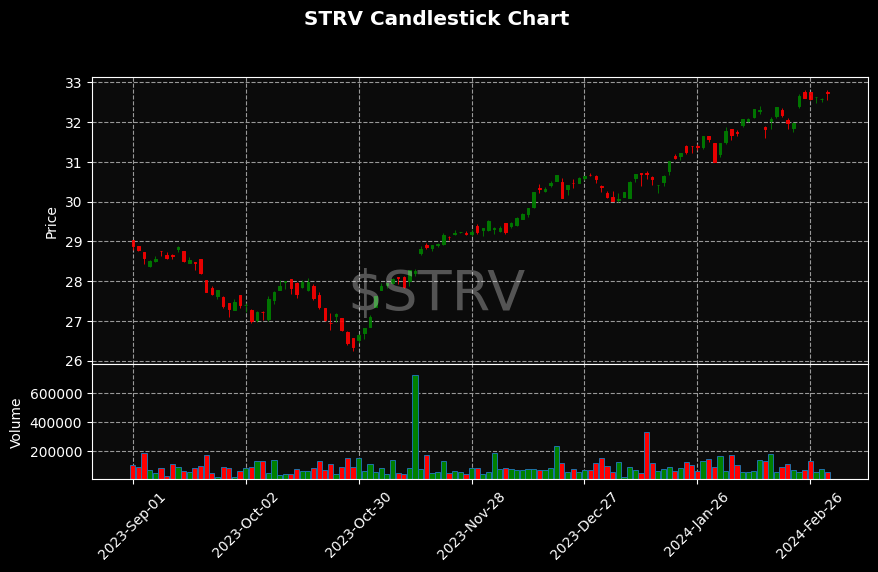

In [324]:
import mplfinance as mpf

# 'STRV' with 'date' as the index
# 'open', 'high', 'low', 'close', and 'volume' cols

# Create a custom market colors style
mc = mpf.make_marketcolors(up='green', down='red', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc)

# Create a figure and axis to plot on, and set the watermark
fig, axlist = mpf.plot(strv_df, type='candle', style=s, volume=True,
                       returnfig=True, title='STRV Candlestick Chart', figratio=(15, 8))

# Get the figure background color
bg_color = fig.get_facecolor()

# Create a watermark by adding text to the figure
fig.text(0.5, 0.5, '$'+'STRV', fontsize=40, color='#ffffff', alpha=0.3,
         ha='center', va='center', rotation='horizontal')

# Show the plot
mpf.show()


#### END -> CHARTS: STRV (S&P 500 ETF) baseline probe test

#### START -> CHARTS: Gap-Up Stocks (returned) data visualizations

In [304]:
"""IDEAs for tomorrow"""

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

'IDEAs for tomorrow'

#### END -> CHARTS: Gap-Up Stocks (returned) data visualizations

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [305]:
# mpf.plot(strv_df, 
#          type='candle', 
#         #  style='mike',  # This is a dark theme
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)


In [306]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [307]:
# i need a math checker for trading days vs calendar days (252/365)

# Yahoo Data
limitations with 60 days of data. there is a workaround to do batching and using time frames if needed.
this is the free option.

In [308]:
# import yfinance as yf
# # Download historical prices from yahoo finance
# start = datetime.now() - timedelta(days=90)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']

# yahoo_df.head(10)

In [309]:
# len(yahoo_df.index)

In [310]:
# # historical data from iex cloud api
# iex_key = os.getenv("IEX_API_KEY")

# def fetch_historical_data(symbols, range='6m'):
#     base_url = 'https://cloud.iexapis.com/stable/stock/market/batch'
#     historical_data = {}

#     # Split symbols into batches if necessary (depending on IEX limits)
#     # For simplicity, assuming all symbols in one batch for now
#     symbols_str = ','.join(symbols)
#     params = {
#         'symbols': symbols_str,
#         'types': 'chart',
#         'range': range,
#         'token': iex_key
#     }
    
#     response = requests.get(base_url, params=params)
#     data = response.json()

#     # Parse the JSON response and convert it into a DataFrame
#     for symbol in symbols:
#         if symbol in data:
#             df = pd.DataFrame(data[symbol]['chart'])
#             df.set_index('date', inplace=True)
#             historical_data[symbol] = df

#     return historical_data

# # Example usage
# symbols = ['AAPL', 'MSFT']  # Assuming these are the symbols returned by your screener
# historical_data = fetch_historical_data(symbols)

# # Access the DataFrame for a specific symbol
# print(historical_data['AAPL'].head())


In [311]:
# # DEV - api test
# # iex cloud - api data request
# iex_key = os.getenv("IEX_API_KEY")
# url = 'https://cloud.iexapis.com/stable/ref-data/symbols?token=' + iex_key
# response = requests.get(url)
# data = response.json()
# symbols_df = pd.DataFrame(data)
# # print 
# symbols_df.head()

In [312]:
# # market cap dataframes
# titans_df = tv_df[tv_df['marketCapType'] == 'Titans']
# large_caps_df = tv_df[tv_df['marketCapType'] == 'Large caps']
# midlers_df = tv_df[tv_df['marketCapType'] == 'Midlers']
# small_caps_df = tv_df[tv_df['marketCapType'] == 'Small caps']
# micro_caps_df = tv_df[tv_df['marketCapType'] == 'Micro caps']
# shrimp_df = tv_df[tv_df['marketCapType'] == 'Shrimp']

# # EXECUTE change percent filter
# titans_df = change_percent_filter(titans_df, .005)
# large_caps_df = change_percent_filter(large_caps_df, .01)
# midlers_df = change_percent_filter(midlers_df, .02)
# small_caps_df = change_percent_filter(small_caps_df, .03)
# micro_caps_df = change_percent_filter(micro_caps_df, .04)
# shrimp_df = change_percent_filter(shrimp_df, .05)

In [313]:
# def change_percent_filter(df, change_percent_min=None ):                               
#     if change_percent_min is not None:
#         df = df[df['Pre-market Change %'] >= change_percent_min]
#     return df  

In [314]:
# # EXECUTE change percent filter
# titans_df = change_percent_filter(titans_df, .005)
# large_caps_df = change_percent_filter(large_caps_df, .01)
# midlers_df = change_percent_filter(midlers_df, .02)
# small_caps_df = change_percent_filter(small_caps_df, .03)
# micro_caps_df = change_percent_filter(micro_caps_df, .04)
# shrimp_df = change_percent_filter(shrimp_df, .05)

In [315]:
# print(len(small_caps_df.index))

In [316]:
# market cap filter function (percentage)

In [317]:
# EXAMPLE IDEA for market cap groups
# microcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Micro-Cap']
# smallcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Small-Cap']
# midcap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mid-Cap']
# largecap_df = screener_df_x[screener_df_x['marketcapType'] == 'Large-Cap']
# megacap_df = screener_df_x[screener_df_x['marketcapType'] == 'Mega-Cap']

In [318]:
# EXAMPLE IDEA for filtering by market cap
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

# THEN we need filters using things like float, volatility, volume, etc. to further filter down the stocks

In [319]:
# def filter_pre_market(df):
#     # Convert 'Pre-market Change %' to numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100
    
#     # Check if conversion resulted in any non-NaN values
#     if df['Pre-market Change %'].isna().all():
#         print("Warning: 'Pre-market Change %' conversion resulted in all NaN values.")
    
#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': '0.005',
#         'Large caps': '0.01',
#         'Midlers': '0.02',
#         'Small caps': '0.03',
#         'Micro caps': '0.04',
#         'Shrimp': '0.05'
#     }

#     # Use the map to apply thresholds
#     threshold_map = df['marketCapType'].map(thresholds)
    
#     # Directly filter using the mapped thresholds
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     # Diagnostic message to check if any rows meet the condition
#     if len(df_filtered) == 0:
#         print("No rows meet the threshold conditions.")
    
#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df_filtered = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df_filtered.index)}')


In [320]:
# def filter_pre_market(df):
#     # Ensure 'Pre-market Change %' is numeric, coercing errors to NaN
#     df['Pre-market Change %'] = pd.to_numeric(df['Pre-market Change %'].str.rstrip('%'), errors='coerce') / 100

#     # Percentage (%) thresholds per market cap type
#     thresholds = {
#         'Titans': 0.005,
#         'Large caps': 0.01,
#         'Midlers': 0.02,
#         'Small caps': 0.03,
#         'Micro caps': 0.04,
#         'Shrimp': 0.05
#     }

#     # Instead of iterating and filtering, use the map to apply thresholds and directly filter
#     threshold_map = df['marketCapType'].map(thresholds)
#     df_filtered = df[df['Pre-market Change %'] >= threshold_map]

#     return df_filtered

# # Assuming tv_df is your initial DataFrame and it's already been categorized by market cap type
# print(f'Length before filtering: {len(tv_df.index)}')
# tv_df = filter_pre_market(tv_df)
# print(f'Length after filtering: {len(tv_df.index)}')


In [321]:
# from IPython.display import display, HTML
# import matplotlib.pyplot as plt
# from datetime import datetime
# import numpy as np

# # Assuming mc_groups is your DataFrame
# # Convert DataFrame to HTML and add custom styling for clearer, larger display
# html = mc_groups.to_html(classes='table table-striped')
# style = """
# <style>
#     .table {float: left; margin-right: 20px;}
#     .table th, .table td {font-size: 18px;}
# </style>
# """
# display(HTML(style + html))

# # Now, plot the donut chart, scaled down a bit, next to the DataFrame
# fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size to scale down the chart

# # Pie chart code here, modified to fit the new figure size
# # Assume your labels, sizes, percentages, and colors are defined as before

# wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, startangle=140,
#                                   autopct='', pctdistance=0.85, wedgeprops=dict(width=0.3))

# # Customizing texts inside the donut as before
# for i, p in enumerate(wedges):
#     angle = (p.theta2 - p.theta1) / 2. + p.theta1
#     y = np.sin(np.deg2rad(angle))
#     x = np.cos(np.deg2rad(angle))
#     percentage = f'{sizes[i]} \n({percentages[i]:.2f}%)'
#     ax.text(x*0.7, y*0.7, percentage, ha='center', va='center', fontsize=8, color='black', weight='bold')

# ax.set_title('Distribution of Market Cap Types', fontsize=12)
# ax.text(0, 0, f'Total: {sizes.sum()}', ha='center', va='center', fontsize=10, color='black', weight='bold')
# ax.text(0, -0.1, datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ha='center', va='center', fontsize=8, color='black', weight='bold')

# plt.axis('equal')
# plt.tight_layout()
# plt.show()


In [322]:
# plt.figure(figsize=(10, 6))
# # Assign 'marketCapType' to both x and hue, and disable the legend.
# sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', legend=False)
# plt.title('Market Cap Type Counts', fontsize=16)
# plt.xlabel('Market Cap Type', fontsize=14)
# plt.ylabel('Count', fontsize=14)
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()

# # Since we're now using 'hue', you'll need to remove the legend explicitly if it still appears.
# plt.legend([],[], frameon=False)

# plt.show()

In [323]:
# feature selection
# features = ['Market capitalization', 'Volume 1 day', 'Volatility 1 week', 'Beta 1 year', 'Sector']
# features = features_raw_all
# target = 'Post-market Change %'

# # Preprocessing data: Drop rows with missing values in the selected columns
# tv_clean_df = trading_view_raw_df[features + [target]].dropna()

# # Check the unique values and their frequency for the target variable
# print(tv_clean_df['Post-market Change %'].value_counts())


# # Encoding categorical variables and scaling numerical variables
# categorical_features = ['Sector']
# numeric_features = list(set(features) - set(categorical_features))

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Prepare the data for modeling
# X = tv_clean_df[features]
# y = tv_clean_df[target]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define and fit the model
# model = Pipeline(steps=[('preprocessor', preprocessor),
#                         ('regressor', LinearRegression())])

# model.fit(X_train, y_train)

# # Predict and evaluate the model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'MSE: {mse}')
# print(f'R^2: {r2}')

# # For detailed statistics, we need to fit the model using statsmodels
# # We'll prepare the data again because statsmodels requires it to be done differently
# X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
# X_train_transformed = sm.add_constant(X_train_transformed)  # Adding a constant for the intercept

# # Fit the model using OLS
# ols_model = sm.OLS(y_train, X_train_transformed).fit()

# # Print the summary of the model to see detailed statistics
# print(ols_model.summary())
